<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose3 in colab with a GPU

<font size = 4>Cellpose3 now allows you to restore and segment noisy/blurry/low res images!

For more details on Cellpose3 check out the [paper](https://www.biorxiv.org/content/10.1101/2024.02.10.579780v1).

Mount your google drive to access all your image files. This also ensures that the segmentations are saved to your google drive.

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [3]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [4]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Sun Feb 16 22:53:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0       

## Images

Load in your own data or use ours (below)

100%|██████████| 28.0M/28.0M [00:01<00:00, 28.5MB/s]


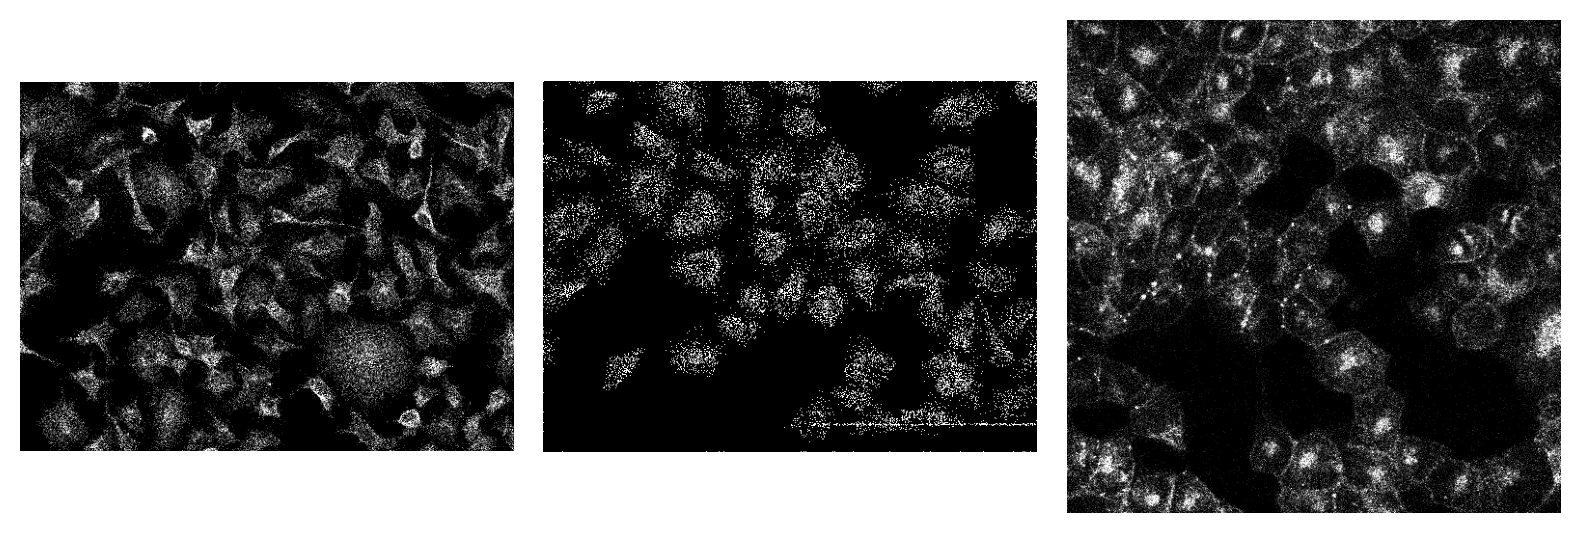

In [5]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200
from cellpose import utils, io

# download noisy images from website
url = "http://www.cellpose.org/static/data/test_poisson.npz"
filename = "test_poisson.npz"
utils.download_url_to_file(url, filename)
dat = np.load(filename, allow_pickle=True)["arr_0"].item()

imgs = dat["test_noisy"]
plt.figure(figsize=(8,3))
for i, iex in enumerate([2, 18, 20]):
    img = imgs[iex].squeeze()
    plt.subplot(1,3,1+i)
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
plt.tight_layout()
plt.show()

Mount your google drive here if you want to load your own images:

In [6]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## run denoising and segmentation

In [ ]:
# RUN CELLPOSE3

from cellpose import denoise, io

io.logger_setup() # run this to get printing of progress

# DEFINE CELLPOSE MODEL
# model_type="cyto3" or "nuclei", or other model
# restore_type: "denoise_cyto3", "deblur_cyto3", "upsample_cyto3", "denoise_nuclei", "deblur_nuclei", "upsample_nuclei"
model = denoise.CellposeDenoiseModel(gpu=True, model_type="cyto3",
                                     restore_type="denoise_cyto3")

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus
# OR if you have different types of channels in each image
# channels = [[2,3], [0,0], [0,0]]

# if you have a nuclear channel, you can use the nuclei restore model on the nuclear channel with
# model = denoise.CellposeDenoiseModel(..., chan2_restore=True)

# NEED TO SPECIFY DIAMETER OF OBJECTS
# in this case we have them from the ground-truth masks
diams = dat["diam_test"]

masks, flows, styles, imgs_dn = model.eval(imgs, diameter=diams, channels=[0,0])


creating new log file


100%|██████████| 25.3M/25.3M [00:00<00:00, 32.3MB/s]
100%|██████████| 25.3M/25.3M [00:00<00:00, 31.5MB/s]


plot results

In [ ]:
plt.figure(figsize=(8,12))
for i, iex in enumerate([2, 18, 20]):
    img = imgs[iex].squeeze()
    plt.subplot(3,3,1+i)
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
    plt.title("noisy")

    img_dn = imgs_dn[iex].squeeze()
    plt.subplot(3,3,4+i)
    plt.imshow(img_dn, cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
    plt.title("denoised")

    plt.subplot(3,3,7+i)
    plt.imshow(img_dn, cmap="gray", vmin=0, vmax=1)
    outlines = utils.outlines_list(masks[iex])
    for o in outlines:
        plt.plot(o[:,0], o[:,1], color=[1,1,0])
    plt.axis('off')
    plt.title("segmentation")

plt.tight_layout()
plt.show()